# Рубежный контроль №2
## Методы построения моделей машинного обучения
### Вариант 19, Используемые методы: дерево решений, градиентный бустинг, датасет StartUp Investments (Crunchbase)

Загрузка необходимых библиотек:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing, tree
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.ensemble import AdaBoostClassifier

Считываем датасет и делаем первичный анализ данных

In [2]:
data = pd.read_csv('../datasets/investments_VC.csv', encoding='latin1', sep=",")
target_col = 'status'
data.shape

(54294, 39)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54294 entries, 0 to 54293
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   permalink             49438 non-null  object 
 1   name                  49437 non-null  object 
 2   homepage_url          45989 non-null  object 
 3   category_list         45477 non-null  object 
 4    market               45470 non-null  object 
 5    funding_total_usd    49438 non-null  object 
 6   status                48124 non-null  object 
 7   country_code          44165 non-null  object 
 8   state_code            30161 non-null  object 
 9   region                44165 non-null  object 
 10  city                  43322 non-null  object 
 11  funding_rounds        49438 non-null  float64
 12  founded_at            38554 non-null  object 
 13  founded_month         38482 non-null  object 
 14  founded_quarter       38482 non-null  object 
 15  founded_year       

Обработаем датасет: избавимся от лишних данных, обработаем пустые значения

In [4]:
data.isnull().mean()

permalink               0.089439
name                    0.089457
homepage_url            0.152963
category_list           0.162394
 market                 0.162523
 funding_total_usd      0.089439
status                  0.113641
country_code            0.186558
state_code              0.444487
region                  0.186558
city                    0.202085
funding_rounds          0.089439
founded_at              0.289903
founded_month           0.291229
founded_quarter         0.291229
founded_year            0.291229
first_funding_at        0.089439
last_funding_at         0.089439
seed                    0.089439
venture                 0.089439
equity_crowdfunding     0.089439
undisclosed             0.089439
convertible_note        0.089439
debt_financing          0.089439
angel                   0.089439
grant                   0.089439
private_equity          0.089439
post_ipo_equity         0.089439
post_ipo_debt           0.089439
secondary_market        0.089439
product_cr

In [5]:
data = data.drop(['permalink','category_list','founded_at', 'founded_month', 'founded_quarter', 'first_funding_at', 'last_funding_at'], axis=1)

data.isnull().sum()

name                     4857
homepage_url             8305
 market                  8824
 funding_total_usd       4856
status                   6170
country_code            10129
state_code              24133
region                  10129
city                    10972
funding_rounds           4856
founded_year            15812
seed                     4856
venture                  4856
equity_crowdfunding      4856
undisclosed              4856
convertible_note         4856
debt_financing           4856
angel                    4856
grant                    4856
private_equity           4856
post_ipo_equity          4856
post_ipo_debt            4856
secondary_market         4856
product_crowdfunding     4856
round_A                  4856
round_B                  4856
round_C                  4856
round_D                  4856
round_E                  4856
round_F                  4856
round_G                  4856
round_H                  4856
dtype: int64

В наборе присутствует 4856 пустых строк, уберем их.

In [6]:
data=data.dropna(how="all")

Пропущенные данные вставим с помощью SimpleImputer-а

In [7]:
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

imputed = {}

for col in data:
    contains_nan = data[col].isnull().sum() != 0
    if contains_nan:
        data_imp = data[[col]]
        data_imp = imp.fit_transform(data_imp)
        imputed[col] = data_imp

for col_name in imputed:
    df = pd.DataFrame({col_name:imputed[col_name].T[0]})
    data[col_name] = df.copy()

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49438 entries, 0 to 49437
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  49438 non-null  object 
 1   homepage_url          49438 non-null  object 
 2    market               49438 non-null  object 
 3    funding_total_usd    49438 non-null  object 
 4   status                49438 non-null  object 
 5   country_code          49438 non-null  object 
 6   state_code            49438 non-null  object 
 7   region                49438 non-null  object 
 8   city                  49438 non-null  object 
 9   funding_rounds        49438 non-null  float64
 10  founded_year          49438 non-null  float64
 11  seed                  49438 non-null  float64
 12  venture               49438 non-null  float64
 13  equity_crowdfunding   49438 non-null  float64
 14  undisclosed           49438 non-null  float64
 15  convertible_note   

Уберём лишние пробелы, также обработаем столбец funding_total_usd так как там встречаются значения вида 11,11,231

In [8]:
data.columns=data.columns.str.strip()

data['funding_total_usd']=data['funding_total_usd'].str.replace(",","")
data["funding_total_usd"]=pd.to_numeric(data["funding_total_usd"],errors="coerce").convert_dtypes()
funding_mode=data['funding_total_usd'].mode()[0]
data['funding_total_usd']=data["funding_total_usd"].fillna(funding_mode)

In [9]:
data.head()

,name,homepage_url,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,...,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,#waywire,http://www.waywire.com,News,1750000,acquired,USA,NY,New York City,New York,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,&TV Communications,http://enjoyandtv.com,Games,4000000,operating,USA,CA,Los Angeles,Los Angeles,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,'Rock' Your Paper,http://www.rockyourpaper.org,Publishing,40000,operating,EST,CA,Tallinn,Tallinn,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,(In)Touch Network,http://www.InTouchNetwork.com,Electronics,1500000,operating,GBR,CA,London,London,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-R- Ranch and Mine,http://app.thotz.co/,Tourism,60000,operating,USA,TX,Dallas,Fort Worth,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
data.select_dtypes('O').describe()

,name,homepage_url,market,status,country_code,state_code,region,city
count,49438,49438,49438,49438,49438,49438,49438,49438
unique,49350,45850,753,3,115,61,1089,4188
top,Roost,http://app.thotz.co/,Software,operating,USA,CA,SF Bay Area,San Francisco
freq,5,3451,8588,43143,34066,29194,12077,8731


Закодируем строковые признаки с помощью LabelEncoder

In [11]:
encoder_name=LabelEncoder()
encoder_market=LabelEncoder()
encoder_country_code=LabelEncoder()
encoder_homepage_url=LabelEncoder()
encoder_status=LabelEncoder()
encoder_state_code=LabelEncoder()
encoder_city=LabelEncoder()
encoder_region=LabelEncoder()

data['name']=encoder_name.fit_transform(data['name'])
data['market']=encoder_market.fit_transform(data['market'])
data['country_code']=encoder_country_code.fit_transform(data['country_code'])
data['status']=encoder_homepage_url.fit_transform(data['status'])
data['homepage_url']=encoder_homepage_url.fit_transform(data['homepage_url'])
data['state_code']=encoder_state_code.fit_transform(data['state_code'])
data['city']=encoder_city.fit_transform(data['city'])
data['region']=encoder_region.fit_transform(data['region'])

data.head()

,name,homepage_url,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,...,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,0,43610,465,1750000,0,110,40,699,2547,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,4422,277,4000000,2,110,6,570,2098,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,37197,543,40000,2,35,6,956,3645,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,15435,211,1500000,2,38,6,568,2085,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,1124,683,60000,2,110,53,251,1234,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Построим матрицу корреляций

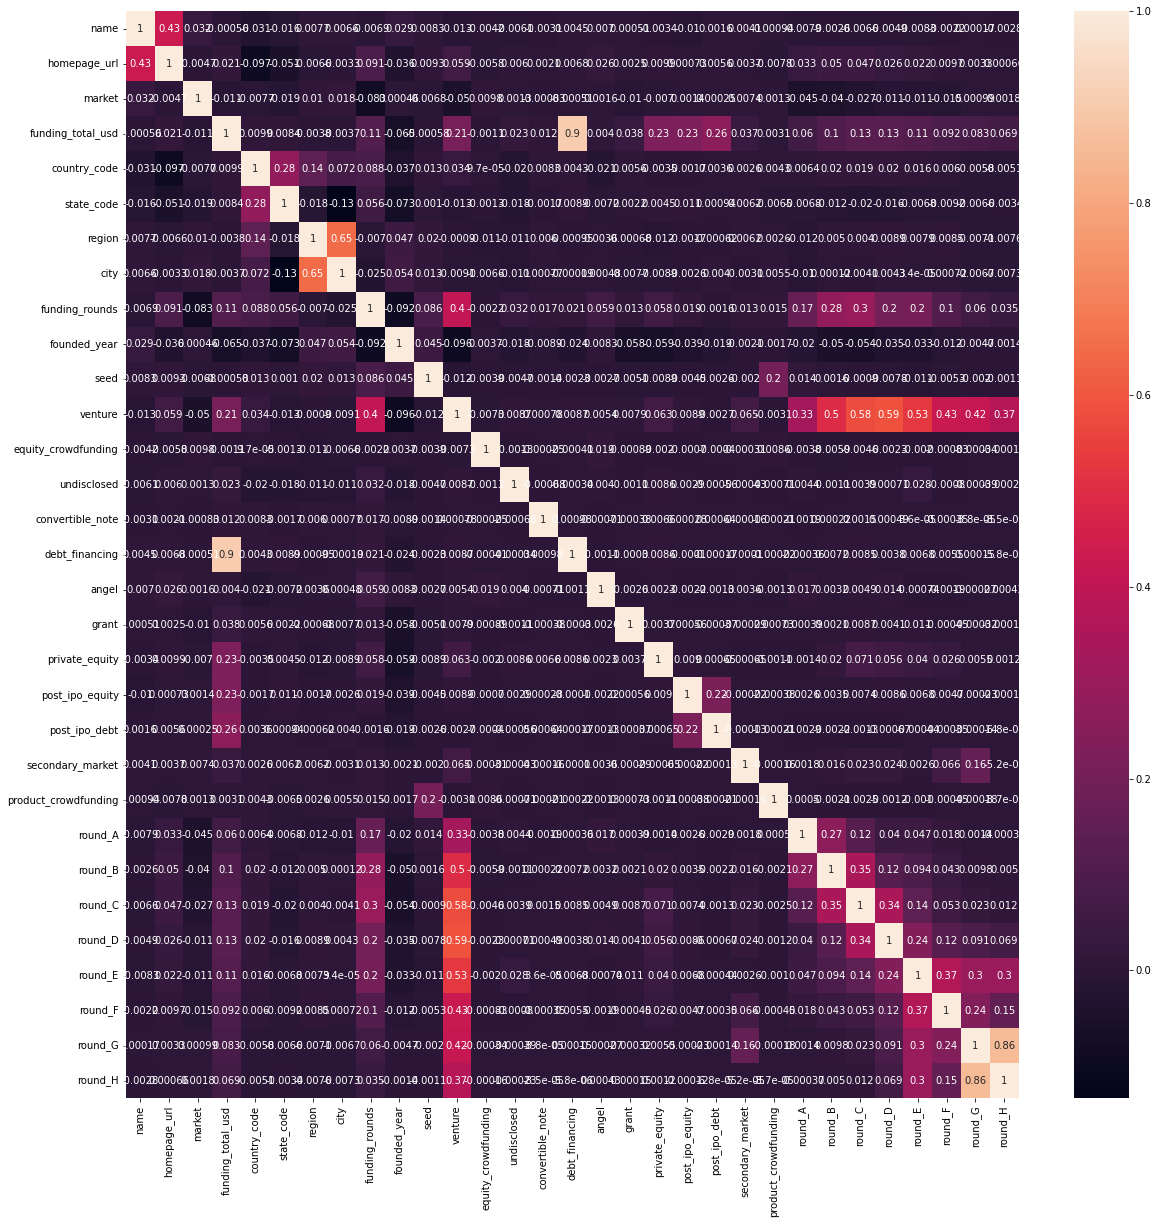

In [12]:
data_corr=data.drop("status",axis=1).corr()
plt.figure(figsize=(20,20))
sns.heatmap(data_corr,annot=True)
plt.show()

Делим выборку на обучающую и тестовую

In [13]:
target = data[target_col] #target_col == 'status'
data_x_train, data_x_test, data_y_train, data_y_test = train_test_split(data, target, test_size=0.4, random_state=1)
data_x_train.shape

(29662, 32)

In [14]:
data_x_test.shape

(19776, 32)

### Применим метод: Дерево решений

In [15]:
model = DecisionTreeClassifier()
model.fit(data_x_train, data_y_train)

DecisionTreeClassifier()

[Text(0.6, 0.8333333333333334, 'X[4] <= 1.5\ngini = 0.228\nsamples = 29662\nvalue = [2214, 1521, 25927]'),
 Text(0.4, 0.5, 'X[4] <= 0.5\ngini = 0.483\nsamples = 3735\nvalue = [2214, 1521, 0]'),
 Text(0.2, 0.16666666666666666, 'gini = 0.0\nsamples = 2214\nvalue = [2214, 0, 0]'),
 Text(0.6, 0.16666666666666666, 'gini = 0.0\nsamples = 1521\nvalue = [0, 1521, 0]'),
 Text(0.8, 0.5, 'gini = 0.0\nsamples = 25927\nvalue = [0, 0, 25927]')]

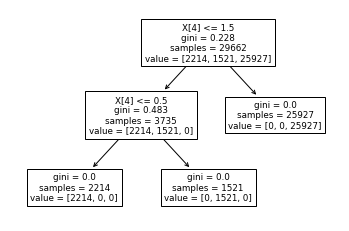

In [16]:
tree.plot_tree(model)

In [17]:
data_y_tree = model.predict(data_x_test)
accuracy_score(data_y_test, data_y_tree)

1.0

In [18]:
f1_score(data_y_test, data_y_tree, average="micro")

1.0

In [19]:
f1_score(data_y_test, data_y_tree, average="macro")

1.0

In [20]:
f1_score(data_y_test, data_y_tree, average="weighted")

1.0

Как видим, у метода дерева решений очень высокая точность.  
### Применим метод градиентного бустинга:

In [21]:
mdl = AdaBoostClassifier()
mdl.fit(data_x_train, data_y_train)
data_y_boost = mdl.predict(data_x_test)
accuracy_score(data_y_test, data_y_boost)

1.0

In [22]:
f1_score(data_y_test, data_y_boost, average="micro")

1.0

In [23]:
f1_score(data_y_test, data_y_boost, average="macro")

1.0

In [24]:
f1_score(data_y_test, data_y_boost, average="weighted")

1.0

### Выводы  
При использовании обоих методов, получили 100% точность. Вероятно, это связанно с особенностями выбранного датасета, т.к. на практике такой результат маловероятен.  
При данных результатах, можно использовать любую из моделей